# Problem Description
RMC, Inc., is a small firm that produces a variety of chemical products. In a particular production process, three raw materials are blended (mixed together) to produce two products:  a fuel additive and a solvent base. Each ton of fuel additive is a mixture of 0.4 tons of material 1 and 0.6 tons of material 3. A ton of solvent base is a mixture of 0.5 tons of material 1, 0.2 tons of  material 2, and 0.3 tons of material 3. After deducting relevant costs, the profit contribution is 40 dollars for every ton of fuel additive produced and 30 dollars for every ton of solvent base produced.  RMC’s production is constrained by a limited availability of the three raw materials. 

Anderson, David R.; Sweeney, Dennis J.; Williams, Thomas A.; Camm, Jeffrey D.; Cochran, James J.. An Introduction to Management Science: Quantitative Approach (p. 63). Cengage Learning.

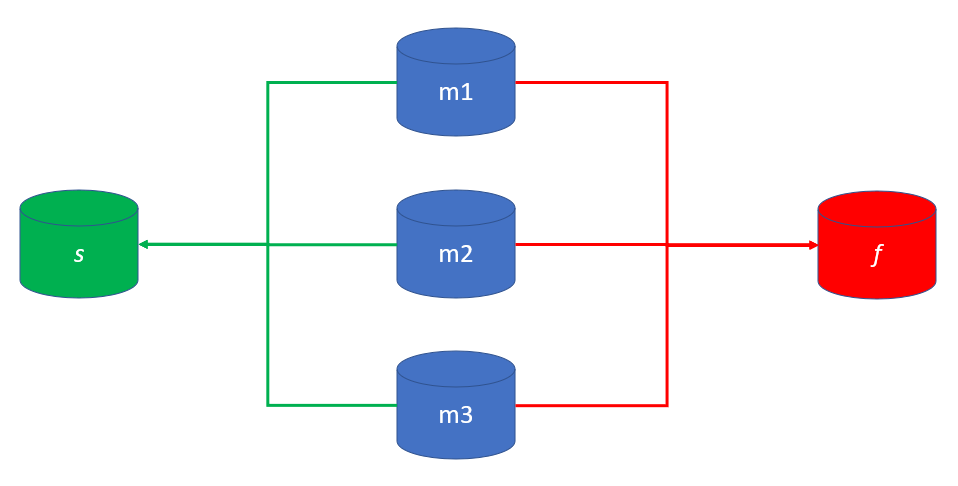

# Opportunity Statement
Maximize profit by determining how much of each product, solvent base and fuel additive, to produce with the raw materials available. 

# Problem Definition
* Solvent base generates a profit of 30 dollars per ton and fuel additive generates a profit of 40 dollars per ton. 
* One ton of solvent base requires 0.5 tons of Material 1, 0.2 tons of Material 2, and 0.3 tons of Material 3. 
* One ton of fuel additive requires 0.4 tons of Material 1 and 0.6 tons of Material 3.
* Profits are maximized for a single period. No multiperiod sales are considered. 
* Raw material availability is limited to 20 tons of Material 1, 5 tons of Material 2, and 21 tons of Material 3. 
* Additional material is not available for purchase.

# Model Development

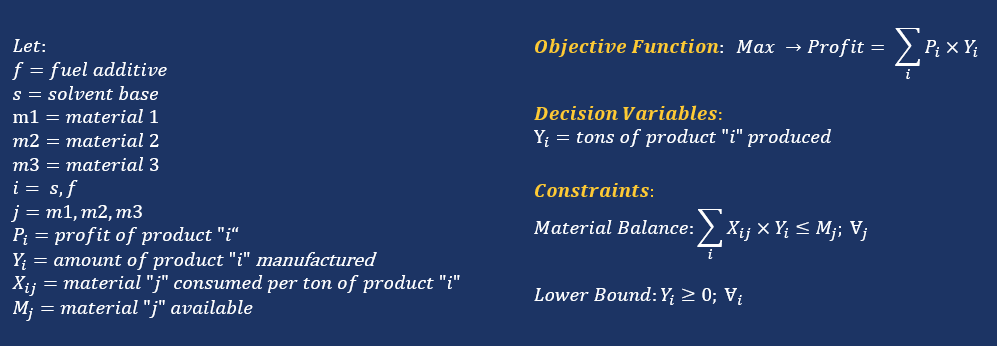

In [1]:
import pandas as pd
import numpy as np
import pulp

In [2]:
#read in data
data_prd = pd.read_excel("3_Data.xlsx","Products")
data_mat = pd.read_excel("3_Data.xlsx","Materials")
data_rec = pd.read_excel("3_Data.xlsx","Recipe")
data_prd

,Product,Price
0,s,30
1,f,40


In [3]:
data_mat

,Material,Available
0,m1,20
1,m2,5
2,m3,21


In [4]:
data_rec

,Product,Material,Cons
0,s,m1,0.5
1,s,m2,0.2
2,s,m3,0.3
3,f,m1,0.4
4,f,m2,0.0
5,f,m3,0.6


In [5]:
#define input parameter values
products=list(data_prd['Product'].unique())
materials=list(data_mat['Material'].unique())

X={}
for p in products:
    X[p]=dict(zip(materials,[None]*len(materials)))
for i in data_rec.index:
    X[data_rec.loc[i,'Product']][data_rec.loc[i,'Material']]=data_rec.loc[i,'Cons']

M=dict(zip(materials,[None]*len(materials)))
for i in data_mat.index:
    M[data_mat.loc[i,'Material']]=data_mat.loc[i,'Available']
    
P=dict(zip(products,[None]*len(products)))
for i in data_prd.index:
    P[data_prd.loc[i,'Product']]=data_prd.loc[i,'Price']

In [6]:
X

{'s': {'m1': 0.5, 'm2': 0.2, 'm3': 0.3},
 'f': {'m1': 0.4, 'm2': 0.0, 'm3': 0.6}}

In [7]:
M

{'m1': 20, 'm2': 5, 'm3': 21}

In [8]:
P

{'s': 30, 'f': 40}

## Build & Solve Model

In [9]:
#Step 1: Create Model Object
model = pulp.LpProblem("Production_Resourcing", pulp.LpMaximize)

In [10]:
#Step 2: Create Decision Variables
Y = pulp.LpVariable.dicts('Y', products, lowBound=0, cat='Continuous')
Y

{'s': Y_s, 'f': Y_f}

In [11]:
#Step 3: Add Objective Function
obj_fxn = 0
obj_fxn += pulp.lpSum(Y[p]*P[p] for p in products)
model += obj_fxn

In [12]:
#Step 4: Add Constraints

for m in materials:
    model += sum([X[p][m]*Y[p] for p in products]) <= M[m], 'Material Balance Constraint' +'_'+str(m)

#NOTE we did note at the non-negative production constraints here because we already specificied them in th e"lowBound" of the LpVariable class. 

In [13]:
#Step 5: Write the Model
model.writeLP("lp_model.lp")

[Y_f, Y_s]

In [14]:
#Step 6: Solve Model
model.solve(pulp.PULP_CBC_CMD(msg=True, keepFiles=False))
pulp.LpStatus[model.status]

'Optimal'

## Evaluation & Sensitivity Analysis

In [15]:
# look at objective value
model.objective.value()

1600.0

In [16]:
#create data frame for df_var
df_var=pd.DataFrame()
lp_class=[]
var=[]
val=[]
rc=[]
for j in model.variables():
    lp_class.append('var')
    var.append(j)
    val.append(j.varValue)
    rc.append(j.dj)

df_var['class']=lp_class
df_var['name']=var
df_var['val']=val
df_var['rc']=rc

df_var

,class,name,val,rc
0,var,Y_f,25.0,0.0
1,var,Y_s,20.0,0.0


In [17]:
#create data frame for df_const
df_const=pd.DataFrame()
lp_class=[]
const=[]
val=[]
slack=[]
dv=[]
for j in model.constraints.items():
    lp_class.append('constraint')
    const.append(j[0])
    val.append(sum([var.varValue * coefficient for var, coefficient in j[1].items()]))
    slack.append(j[1].slack)
    dv.append(j[1].pi)

df_const['class']=lp_class
df_const['name']=const
df_const['val']=val
df_const['slack']=slack
df_const['dv']=dv

df_const

,class,name,val,slack,dv
0,constraint,Material_Balance_Constraint_m1,20.0,-0.0,33.333333
1,constraint,Material_Balance_Constraint_m2,4.0,1.0,-0.000000
2,constraint,Material_Balance_Constraint_m3,21.0,-0.0,44.444444
